
Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




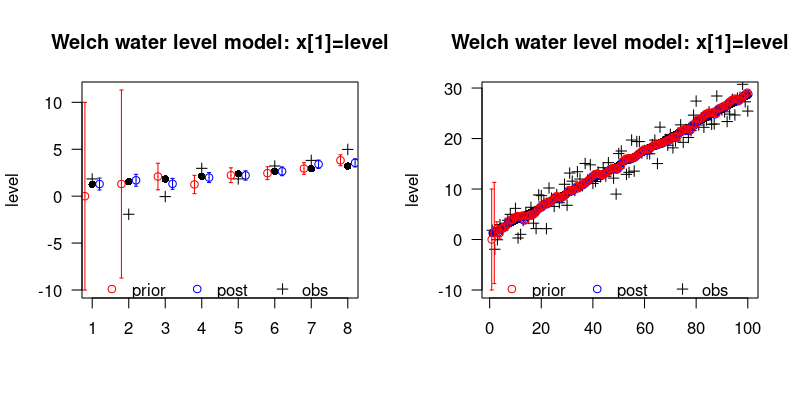

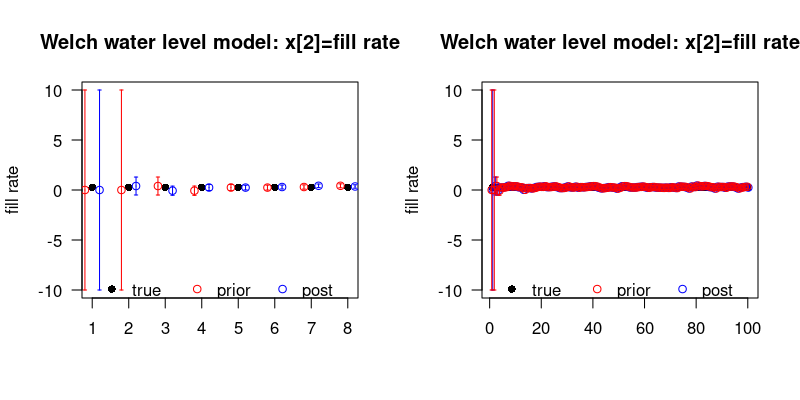

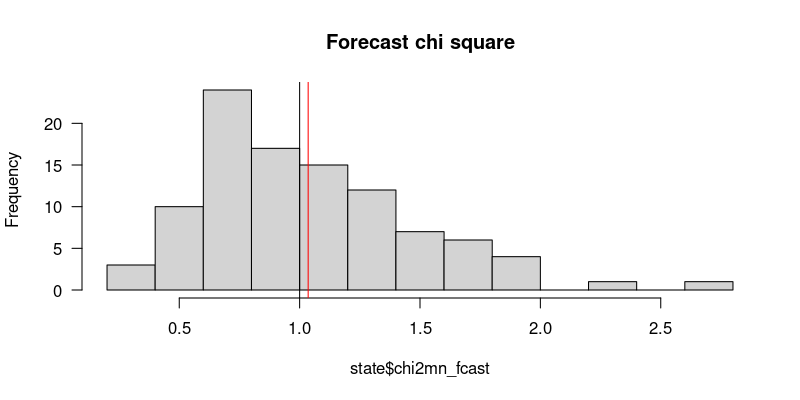

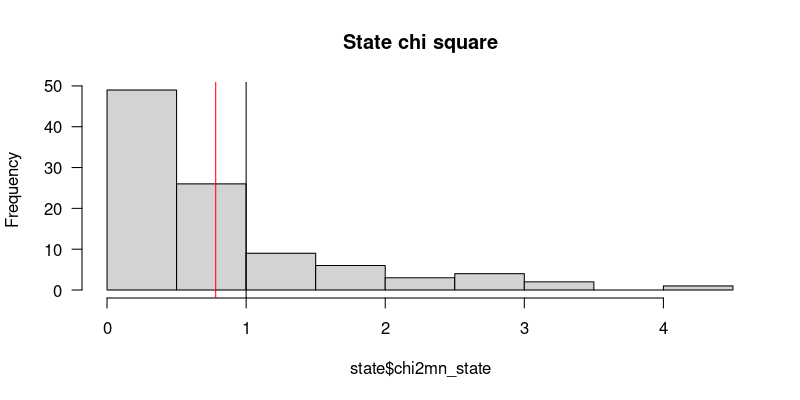

chi2mn fcast: 1.04
chi2mn state: 0.78
no. updates where RMSE is not improved: 48/100 (48.0%)
forecast error:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-6.52291 -1.38179 -0.05873  0.01380  1.44476  6.88880 
normalized forecast error:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-2.927678 -0.675010 -0.004488  0.009133  0.700492  3.141155 
posterior error:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-5.735912 -1.355747 -0.030075 -0.001821  1.351111  6.198422 


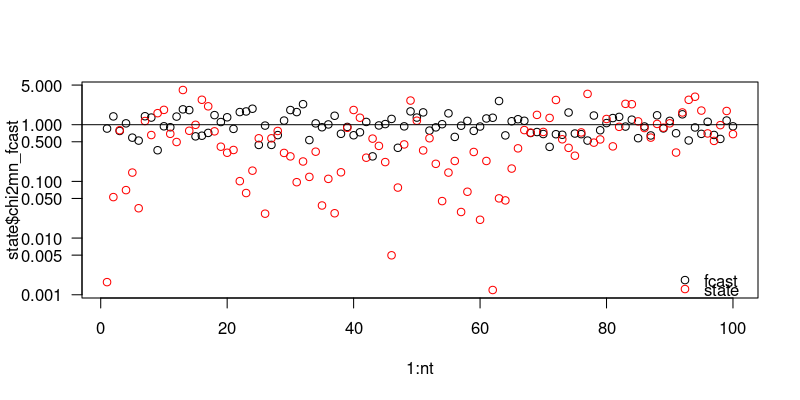

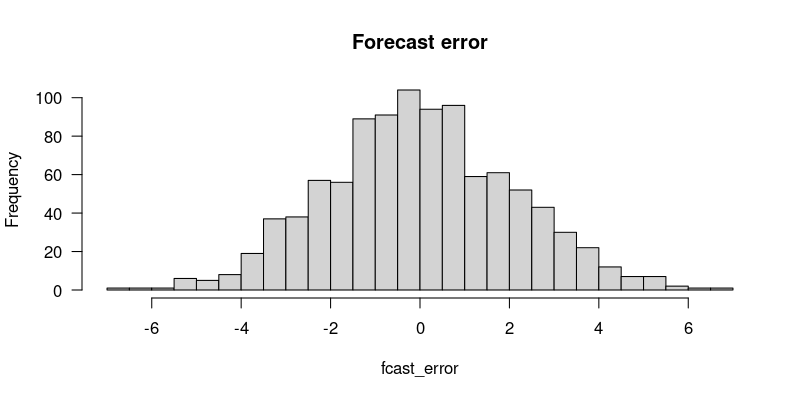

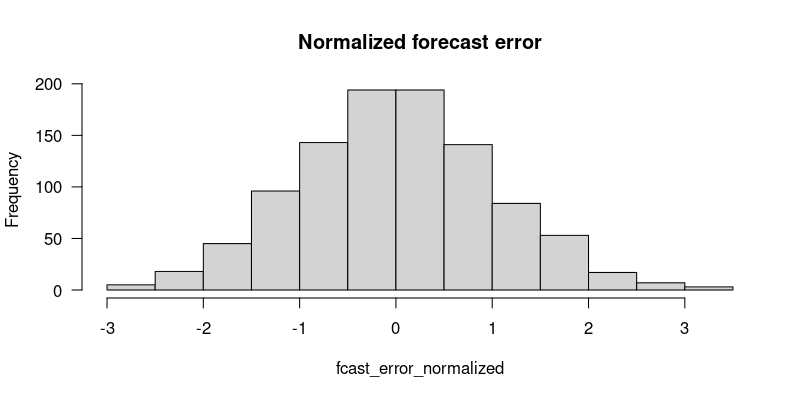

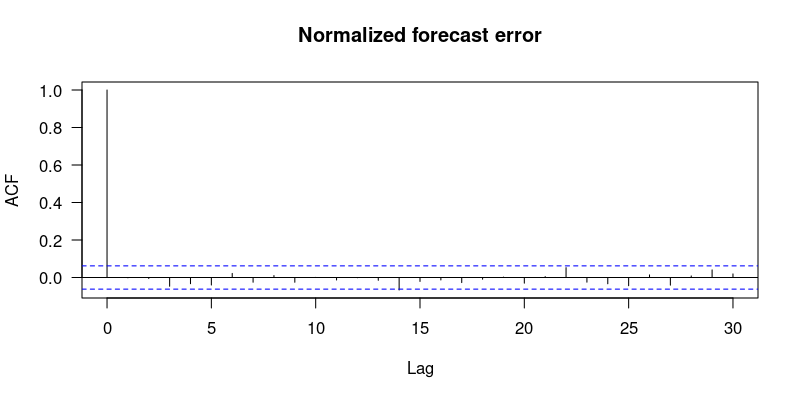

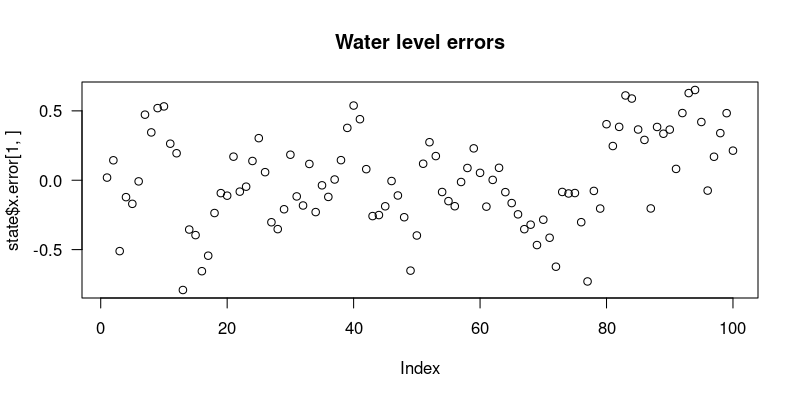

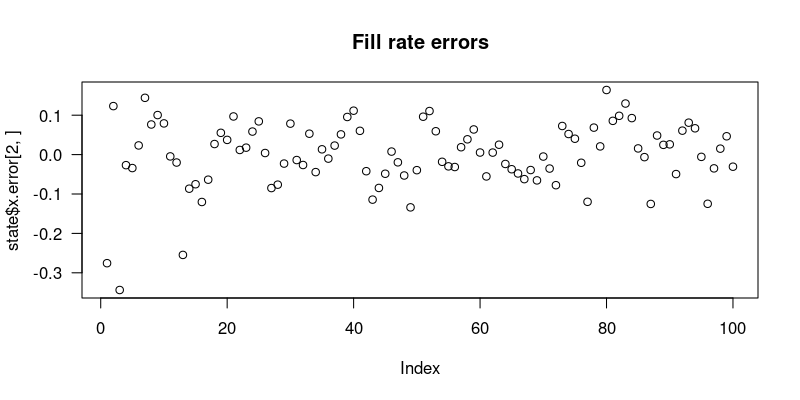

In [1]:
source("kf_support_functions.r")
library('gplots')
library('repr')
options(repr.plot.width=8,repr.plot.height=4,repr.plot.res=100)
verbose <- FALSE

# Water level has a linear trend.
# state is two-dimensional: level and fill rate
nparms <- 2 # no. of unknowns
nobs <- 10 # no. of obs per timestemp
nt <- 100 # no. of timesteps

# measurement mapping: state is observed, fill rate unobserved
H <- matrix(c(rep(1,nobs),rep(0,nobs)),nrow=nobs,ncol=nparms)

deltat <- 1 # time unit
Psi <- matrix(c(1,0,deltat,1),ncol=nparms,nrow=nparms) # persistence except x1[i+1] <- x1[i] + x2[i]*deltat
# process noise variance
Spsi <- 0.5*matrix(c(0.008,0,0,0.013),ncol=nparms,nrow=nparms) 

x0 <- matrix(c(0,0),ncol=1,nrow=nparms) # initial state
Sx0 <- matrix(c(100,0,0,100),nrow=nparms,ncol=nparms) # initial state (variance)

sz <- 2 # measurement noise (std dev)
Sz <- diag(rep(sz^2,nobs)) #  measurement noise (variance)
z <- matrix(NA,ncol=nt,nrow=nobs) # measurements

state <- list()
state$x.prior <- array(NA,dim=c(nparms,nt))
state$Sx.prior <- array(NA,dim=c(nparms,nparms,nt))
state$x.post <- array(NA,dim=c(nparms,nt))
state$Sx.post <- array(NA,dim=c(nparms,nparms,nt))
state$chi2mn_fcast <- rep(NA,nt)
state$chi2mn_state <- rep(NA,nt)
state$x.error <- array(NA,dim=c(nparms,nt))
state$rmse_post <- rep(NA,nt)
state$rmse_prior <- rep(NA,nt)

# empty vectors to store concatenated output from measurement.update()
fcast_error <- numeric(0)
fcast_error_normalized <- numeric(0)
post_error <- numeric(0)

# true fill rate
#f <- 0.5
#f <- rnorm(mean=0.5,sd=0.1,n=1)
f <- runif(n=1) # 0-1
#f <- rnorm(mean=0.5,sd=0.1,n=n)  # consider a variable fill rate

state$xtrue <- array(NA,dim=c(nparms,nt))
state$xtrue[1,] <- 1 + f*(1:nt) # state (level)
state$xtrue[2,] <- rep(f,nt) # fill rate


nodd <- 0

for (i in 1:nt) {

  # predict (time propagation)
    
  if(i==1) {
    state$x.prior[,i] <- x0
    state$Sx.prior[,,i] <- Sx0
  } else {
    state$x.prior[,i] <- Psi %*% state$x.post[,i-1]
    state$Sx.prior[,,i] <- Psi %*% state$Sx.post[,,i-1] %*% t(Psi) + Spsi
  }

  # measurement update
  
  z[,i] <- H %*% state$xtrue[,i] + rnorm(n=nobs,mean=0,sd=sz)

  # make everything a matrix
  post <- measurement.update(x=matrix(state$x.prior[,i],nrow=nparms,ncol=1),
                             Sx=state$Sx.prior[,,i],
                             H=H,
                             z=matrix(z[,i],ncol=1,nrow=nobs),
			     Sz=Sz,
			     xtrue=state$xtrue[,i],
			     verbose=verbose)
			     
  state$x.post[,i] <- post$x
  state$Sx.post[,,i] <- post$Sx

  state$chi2mn_fcast[i] <- post$chi2mn_fcast
  state$chi2mn_state[i] <- post$chi2mn_state

  state$rmse.post[i] <- compute.rmse(state$x.post[,i]-state$xtrue[,i])
  state$rmse.prior[i] <- compute.rmse(state$x.prior[,i]-state$xtrue[,i])

  state$x.error[,i] <- post$x.error
  
  fcast_error <- c(fcast_error,post$fcast_error)
  fcast_error_normalized <- c(fcast_error_normalized,post$fcast_error_normalized)
  post_error <- c(post_error,post$post_error)

  if(state$rmse.post[i] > state$rmse.prior[i]) {
    if(verbose) {
      cat(sprintf("[%d] Warning: RMSE post (%.2g) > RMSE prior (%.2g)\n",i,state$rmse.post[i],state$rmse.prior[i]))
    }
    nodd <- nodd+1
  }	 

}

par(las=1) # numbers on y axis right-side up.

layout(matrix(1:2,nrow=1))

options(warn=-1) # suppress "zero-length arrow" messages from plotCI()

lx <- 1:8
these.ylims <- range(c(z[lx],state$x.prior[1,lx]+c(-1,1)*sqrt(state$Sx.prior[1,1,lx])),na.rm=TRUE)
plot(lx,z[1,lx],main="Welch water level model: x[1]=level",ylim=these.ylims,pch=3,xlab='',ylab='level')
points(lx,state$xtrue[1,lx],pch=16)
plotCI(x=(lx)+0.2,y=state$x.post[1,lx],uiw=sqrt(state$Sx.post[1,1,lx]),col='blue',err='y',add=TRUE,sfrac=0.005,gap=0)
plotCI(x=(lx)-0.2,y=state$x.prior[1,lx],uiw=sqrt(state$Sx.prior[1,1,lx]),col='red',err='y',add=TRUE,sfrac=0.005,gap=0)
legend(x='bottomright',horiz=T,bty='n',col=c('black','red','blue',"black"),legend=c('true','prior','post','obs'),pch=c(16,1,1,3))

lx <- 1:nt
these.ylims <- range(c(z[lx],state$x.prior[1,lx]+c(-1,1)*sqrt(state$Sx.prior[1,1,lx])),na.rm=TRUE)
plot(lx,z[1,lx],main="Welch water level model: x[1]=level",ylim=these.ylims,pch=3,xlab='',ylab='level')
points(lx,state$xtrue[1,lx],pch=16)
plotCI(x=(lx)+0.2,y=state$x.post[1,lx],uiw=sqrt(state$Sx.post[1,1,lx]),col='blue',err='y',add=TRUE,sfrac=0.005,gap=0)
plotCI(x=(lx)-0.2,y=state$x.prior[1,lx],uiw=sqrt(state$Sx.prior[1,1,lx]),col='red',err='y',add=TRUE,sfrac=0.005,gap=0)
legend(x='bottomright',horiz=T,bty='n',col=c('black','red','blue',"black"),legend=c('true','prior','post','obs'),pch=c(16,1,1,3))

lx <- 1:8
these.ylims <- range(c(state$x.prior[2,lx]+c(-1,1)*sqrt(state$Sx.prior[2,2,lx])),na.rm=TRUE)
plot((lx),state$xtrue[2,lx],pch=16,main="Welch water level model: x[2]=fill rate",ylim=these.ylims,xlab='',ylab='fill rate')
plotCI(x=(lx)+0.2,y=state$x.post[2,lx],uiw=sqrt(state$Sx.post[2,2,lx]),col='blue',err='y',add=TRUE,sfrac=0.005,gap=0)
plotCI(x=(lx)-0.2,y=state$x.prior[2,lx],uiw=sqrt(state$Sx.prior[2,2,lx]),col='red',err='y',add=TRUE,sfrac=0.005,gap=0)
legend(x='bottomright',horiz=T,bty='n',col=c('black','red','blue'),legend=c('true','prior','post'),pch=c(16,1,1))


lx <- 1:nt
these.ylims <- range(c(state$x.prior[2,lx]+c(-1,1)*sqrt(state$Sx.prior[2,2,lx])),na.rm=TRUE)
plot((lx),state$xtrue[2,lx],pch=16,main="Welch water level model: x[2]=fill rate",ylim=these.ylims,xlab='',ylab='fill rate')
plotCI(x=(lx)+0.2,y=state$x.post[2,lx],uiw=sqrt(state$Sx.post[2,2,lx]),col='blue',err='y',add=TRUE,sfrac=0.005,gap=0)
plotCI(x=(lx)-0.2,y=state$x.prior[2,lx],uiw=sqrt(state$Sx.prior[2,2,lx]),col='red',err='y',add=TRUE,sfrac=0.005,gap=0)
legend(x='bottomright',horiz=T,bty='n',col=c('black','red','blue'),legend=c('true','prior','post'),pch=c(16,1,1))


layout(matrix(1,1,1))

hist(state$chi2mn_fcast,10,main="Forecast chi square")
abline(v=c(1,mean(state$chi2mn_fcast)),col=c('black','red'))

hist(state$chi2mn_state,10,main="State chi square")
abline(v=c(1,mean(state$chi2mn_state)),col=c('black','red'))

plot(1:nt,state$chi2mn_fcast,ylim=range(c(state$chi2mn_fcast,state$chi2mn_state)),log='y')
points(1:nt,state$chi2mn_state,col='red')
legend(x='bottomright',bty='n',pch=1,col=c('black','red'),legend=c('fcast','state'))
abline(h=1)

cat(sprintf("chi2mn fcast: %.2f\n",mean(state$chi2mn_fcast)))
cat(sprintf("chi2mn state: %.2f\n",mean(state$chi2mn_state)))
cat(sprintf("no. updates where RMSE is not improved: %d/%d (%.1f%%)\n",
            nodd,nt,100*nodd/nt))

cat("forecast error:\n")
print(summary(fcast_error))
cat("normalized forecast error:\n")
print(summary(fcast_error_normalized))
cat("posterior error:\n")
print(summary(post_error))
hist(fcast_error,20,main="Forecast error")
hist(fcast_error_normalized,20,main="Normalized forecast error")

acf(fcast_error_normalized,main="Normalized forecast error")
plot(state$x.error[1,],main="Water level errors")
plot(state$x.error[2,],main="Fill rate errors")
